Tests to implement:

1. KDD/GDD biases
2. LH/SH biases
3. Do these biases scale with ag production
4. Do these biases change over the growing season
5. Do historical cmip6 temperature biases predict future changes

In [2]:
import xarray as xr
import xesmf as xe
import numpy as np
import matplotlib.pyplot as plt
import scipy
import statsmodels.api as sm
import cartopy
import cartopy.util
import cartopy.crs as ccrs
import glob
import sys, os
import pickle, gzip
import datetime

In [3]:
run ../util/setupConsole_su

In [4]:
dirCmip6 = '/home/edcoffel/drive/MAX-Filer/Research/Climate-02/Data-02-edcoffel-F20/CMIP6'
dirERA5 = '/home/edcoffel/drive/MAX-Filer/Research/Climate-02/Data-02-edcoffel-F20/ERA5'
dirDeepak = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/data/projects/ag-land-climate/deepak'
dirAgData = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/data/projects/ag-land-climate'
dirProj = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/research/2020-ag-cmip6'
dirSacks = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/data/projects/ag-land-climate'


In [5]:
# files = glob.glob('%s/cmip6_output/*.nc'%dirProj)
# for f in files:
#     os.rename(f,'%s.nc'%f[0:-4]) 

In [6]:
with gzip.open('%s/gdd-kdd-lat-era5.dat'%dirAgData, 'rb') as f:
    era5_lat = pickle.load(f)
with gzip.open('%s/gdd-kdd-lon-era5.dat'%dirAgData, 'rb') as f:
    era5_lon = pickle.load(f)

In [7]:
cmip6_models = ['access-cm2', 'access-esm1-5', 'awi-cm-1-1-mr', 'bcc-csm2-mr', 'bcc-esm1', 'canesm5', 'ec-earth3', \
                'gfdl-cm4', 'gfdl-esm4', 'giss-e2-1-g', 'kace-1-0-g', 'fgoals-g3', 'inm-cm5-0', 'ipsl-cm6a-lr', 'miroc6', \
                'mpi-esm1-2-hr', 'mpi-esm1-2-lr', 'mri-esm2-0', 'noresm2-lm', 'noresm2-mm', 'sam0-unicon']

In [8]:
region = 'global'
crop = 'Maize'
if region == 'global':
    latRange = [-90, 90]
    lonRange = [0, 360]
elif region == 'us':
    latRange = [20, 57]
    lonRange = [220, 300]
elif region == 'china':
    latRange = [25, 45]
    lonRange = [105, 123]
elif region == 'eu':
    latRange = [38, 56]
    lonRange = [-5, 40]

latIndRange_era5 = np.where((era5_lat >= latRange[0]) & (era5_lat <= latRange[1]))[0]
lonIndRange_era5 = np.where((era5_lon >= lonRange[0]) & (era5_lon <= lonRange[1]))[0]

regridMesh_current = xr.Dataset({'lat': (['lat'], np.arange(latRange[0], latRange[1], 1.5)),
                            'lon': (['lon'], np.arange(lonRange[0], lonRange[1], 1.5)),})

regridMesh_global = xr.Dataset({'lat': (['lat'], np.arange(-90, 90, 1.5)),
                                'lon': (['lon'], np.arange(0, 360, 1.5)),})


if region == 'global':
    regridMesh = regridMesh_global
else:
    regridMesh = regridMesh_current

In [9]:
sacksMaizeNc = xr.open_dataset('%s/sacks/%s.crop.calendar.fill.nc'%(dirSacks, crop))
sacksStart = sacksMaizeNc['plant'].values
sacksStart = np.roll(sacksStart, -int(sacksStart.shape[1]/2), axis=1)
sacksStart[sacksStart < 0] = np.nan
sacksEnd = sacksMaizeNc['harvest'].values
sacksEnd = np.roll(sacksEnd, -int(sacksEnd.shape[1]/2), axis=1)
sacksEnd[sacksEnd < 0] = np.nan

In [10]:
with open('cropped_area/crop_land_regrid.dat', 'rb') as f:
    crop_all_area_regrid = pickle.load(f)
with open('cropped_area/pasture_land_regrid.dat', 'rb') as f:
    pasture_area_regrid = pickle.load(f)

In [11]:
cmip6_tasmax_grow_max = xr.Dataset()
cmip6_tasmax_grow_mean = xr.Dataset()
cmip6_ef_grow = xr.Dataset()
cmip6_mrso_grow = xr.Dataset()
cmip6_pr_grow = xr.Dataset()
cmip6_tran_grow = xr.Dataset()
cmip6_evspsblveg_grow = xr.Dataset()
cmip6_evspsblsoi_grow = xr.Dataset()
cmip6_cropFrac_grow = xr.Dataset()

ef_m = 0
mrso_m = 0
pr_m = 0
tran_m = 0
evspsblveg_m = 0
evspsblsoi_m = 0
cropFrac_m = 0

for m, model in enumerate(cmip6_models):

    if not os.path.isfile('cmip6_output/growing_season/cmip6_%s_tasmax_grow_max_%s_%s_regrid.nc'%(crop, region, model)):
        print('skipping tasmax max %s'%model)
        
        continue
    
#     print('loading regridded growing season tasmax for %s'%model)

    ds_global_txx = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_tasmax_grow_max_%s_%s_regrid.nc'%(crop, region, model))
    ds_global_t50p = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_tasmax_grow_mean_%s_%s_regrid.nc'%(crop, region, model))
    
    if m == 0:
        cmip6_tasmax_grow_max = ds_global_txx
        cmip6_tasmax_grow_mean = ds_global_t50p
    else:
        cmip6_tasmax_grow_max = xr.concat([cmip6_tasmax_grow_max, ds_global_txx], dim='model')
        cmip6_tasmax_grow_mean = xr.concat([cmip6_tasmax_grow_mean, ds_global_t50p], dim='model')
    
    
    if os.path.isfile('cmip6_output/growing_season/cmip6_%s_grow_ef_mon_global_%s_regrid.nc'%(crop, model)):
        ds_global_ef = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_grow_ef_mon_global_%s_regrid.nc'%(crop, model))
        
        if ef_m == 0:
            cmip6_ef_grow = ds_global_ef
        else:
            cmip6_ef_grow = xr.concat([cmip6_ef_grow, ds_global_ef], dim='model')
        ef_m += 1
    else:
        print('skipping ef %s'%model)
        
    if os.path.isfile('cmip6_output/growing_season/cmip6_%s_grow_mrso_mon_global_%s_regrid.nc'%(crop, model)):
        ds_global_mrso = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_grow_mrso_mon_global_%s_regrid.nc'%(crop, model))
        
        if mrso_m == 0:
            cmip6_mrso_grow = ds_global_mrso
        else:
            cmip6_mrso_grow = xr.concat([cmip6_mrso_grow, ds_global_mrso], dim='model')
        mrso_m += 1
    else:
        print('skipping mrso %s'%model)
        
    if os.path.isfile('cmip6_output/growing_season/cmip6_%s_grow_pr_mean_global_%s_regrid.nc'%(crop, model)):
        ds_global_pr = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_grow_pr_mean_global_%s_regrid.nc'%(crop, model))
        
        if pr_m == 0:
            cmip6_pr_grow = ds_global_pr
        else:
            cmip6_pr_grow = xr.concat([cmip6_pr_grow, ds_global_pr], dim='model')
        pr_m += 1
    else:
        print('skipping pr %s'%model)
        
    if os.path.isfile('cmip6_output/growing_season/cmip6_%s_grow_tran_mon_global_%s_regrid.nc'%(crop, model)):
        ds_global_tran = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_grow_tran_mon_global_%s_regrid.nc'%(crop, model))
        
        if tran_m == 0:
            cmip6_tran_grow = ds_global_tran
        else:
            cmip6_tran_grow = xr.concat([cmip6_tran_grow, ds_global_tran], dim='model')
        tran_m += 1
    else:
        print('skipping tran %s'%model)
        
    
    if os.path.isfile('cmip6_output/growing_season/cmip6_%s_grow_evspsblveg_mon_global_%s_regrid.nc'%(crop, model)):
        ds_global_evspsblveg = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_grow_evspsblveg_mon_global_%s_regrid.nc'%(crop, model))
        
        if evspsblveg_m == 0:
            cmip6_evspsblveg_grow = ds_global_evspsblveg
        else:
            cmip6_evspsblveg_grow = xr.concat([cmip6_evspsblveg_grow, ds_global_evspsblveg], dim='model')
        evspsblveg_m += 1
    else:
        print('skipping evspsblveg %s'%model)
        
        
    if os.path.isfile('cmip6_output/growing_season/cmip6_%s_grow_evspsblsoi_mon_global_%s_regrid.nc'%(crop, model)):
        ds_global_evspsblsoi = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_grow_evspsblsoi_mon_global_%s_regrid.nc'%(crop, model))
        
        if evspsblsoi_m == 0:
            cmip6_evspsblsoi_grow = ds_global_evspsblsoi
        else:
            cmip6_evspsblsoi_grow = xr.concat([cmip6_evspsblsoi_grow, ds_global_evspsblsoi], dim='model')
        evspsblsoi_m += 1
    else:
        print('skipping evspsblsoi %s'%model)
    
        
    if os.path.isfile('cmip6_output/growing_season/cmip6_%s_grow_cropFrac_mon_global_%s_regrid.nc'%(crop, model)):
        ds_global_cropFrac = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_grow_cropFrac_mon_global_%s_regrid.nc'%(crop, model))
        
        if cropFrac_m == 0:
            cmip6_cropFrac_grow = ds_global_cropFrac
        else:
            cmip6_cropFrac_grow = xr.concat([cmip6_cropFrac_grow, ds_global_cropFrac], dim='model')
        cropFrac_m += 1
    else:
        print('skipping cropFrac %s'%model)


skipping tran access-cm2
skipping evspsblveg access-cm2
skipping evspsblsoi access-cm2
skipping tran access-esm1-5
skipping evspsblveg access-esm1-5
skipping mrso awi-cm-1-1-mr
skipping pr awi-cm-1-1-mr
skipping tran awi-cm-1-1-mr
skipping evspsblveg awi-cm-1-1-mr
skipping evspsblsoi awi-cm-1-1-mr
skipping cropFrac awi-cm-1-1-mr
skipping pr bcc-csm2-mr
skipping cropFrac bcc-csm2-mr
skipping cropFrac bcc-esm1
skipping tran ec-earth3
skipping evspsblveg ec-earth3
skipping evspsblsoi ec-earth3
skipping cropFrac ec-earth3
skipping ef gfdl-cm4
skipping pr gfdl-cm4
skipping evspsblveg gfdl-cm4
skipping evspsblsoi gfdl-cm4
skipping ef gfdl-esm4
skipping evspsblveg gfdl-esm4
skipping evspsblsoi gfdl-esm4
skipping mrso giss-e2-1-g
skipping pr giss-e2-1-g
skipping evspsblveg giss-e2-1-g
skipping evspsblsoi giss-e2-1-g
skipping cropFrac giss-e2-1-g
skipping ef kace-1-0-g
skipping mrso kace-1-0-g
skipping tran kace-1-0-g
skipping cropFrac kace-1-0-g
skipping evspsblveg fgoals-g3
skipping evspsblso

In [27]:
# LOAD FUTURE DATA

cmip6_tasmax_grow_max_ssp245 = xr.Dataset()
cmip6_pr_grow_ssp245 = xr.Dataset()
cmip6_ef_grow_ssp245 = xr.Dataset()

for m, model in enumerate(cmip6_models):

    if not os.path.isfile('cmip6_output/growing_season/cmip6_%s_tasmax_grow_ssp245_max_%s_%s_regrid.nc'%(crop, region, model)):
        print('skipping tasmax max %s'%model)
    else:
        ds_global_txx = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_tasmax_grow_ssp245_max_%s_%s_regrid.nc'%(crop, region, model))
        ds_global_t50p = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_tasmax_grow_ssp245_mean_%s_%s_regrid.nc'%(crop, region, model))

        if m == 0:
            cmip6_tasmax_grow_max_ssp245 = ds_global_txx
            cmip6_tasmax_grow_mean_ssp245 = ds_global_t50p
        else:
            cmip6_tasmax_grow_max_ssp245 = xr.concat([cmip6_tasmax_grow_max_ssp245, ds_global_txx], dim='model')
            cmip6_tasmax_grow_mean_ssp245 = xr.concat([cmip6_tasmax_grow_mean_ssp245, ds_global_t50p], dim='model')
            
    
    if not os.path.isfile('cmip6_output/growing_season/cmip6_%s_pr_grow_ssp245_mean_%s_%s_regrid.nc'%(crop, region, model)):
        print('skipping pr %s'%model)
    else:
        ds_global_pr = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_pr_grow_ssp245_mean_%s_%s_regrid.nc'%(crop, region, model))

        if m == 0:
            cmip6_pr_grow_ssp245 = ds_global_pr
        else:
            cmip6_pr_grow_ssp245 = xr.concat([cmip6_pr_grow_ssp245, ds_global_pr], dim='model')

            
            
    if not os.path.isfile('cmip6_output/growing_season/cmip6_%s_ef_grow_ssp245_mean_%s_%s_regrid.nc'%(crop, region, model)):
        print('skipping ef %s'%model)
    else:
        ds_global_ef = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_ef_grow_ssp245_mean_%s_%s_regrid.nc'%(crop, region, model))

        if m == 0:
            cmip6_ef_grow_ssp245 = ds_global_ef
        else:
            cmip6_ef_grow_ssp245 = xr.concat([cmip6_ef_grow_ssp245, ds_global_ef], dim='model')


skipping tasmax max awi-cm-1-1-mr
skipping tasmax max bcc-esm1
skipping pr bcc-esm1
skipping ef bcc-esm1
skipping tasmax max gfdl-cm4
skipping pr gfdl-cm4
skipping ef gfdl-cm4
skipping tasmax max gfdl-esm4
skipping tasmax max giss-e2-1-g
skipping pr giss-e2-1-g
skipping ef giss-e2-1-g
skipping tasmax max kace-1-0-g
skipping tasmax max fgoals-g3
skipping tasmax max inm-cm5-0
skipping ef inm-cm5-0
skipping tasmax max mpi-esm1-2-hr
skipping tasmax max mpi-esm1-2-lr
skipping ef mpi-esm1-2-lr
skipping ef noresm2-lm
skipping tasmax max sam0-unicon
skipping pr sam0-unicon
skipping ef sam0-unicon


In [28]:
# load cmip6 change


# calc temp change between historical cmip6 and ssp245

tasmax_grow_max_chg_ssp245 = np.full([len(cmip6_models), \
                                      cmip6_tasmax_grow_max.lat.values.shape[0], \
                                  cmip6_tasmax_grow_max.lon.values.shape[0]], np.nan)

pr_grow_chg_ssp245 = np.full([len(cmip6_models), \
                              cmip6_pr_grow.lat.values.shape[0], \
                              cmip6_pr_grow.lon.values.shape[0]], np.nan)

ef_grow_chg_ssp245 = np.full([len(cmip6_models), \
                              cmip6_ef_grow.lat.values.shape[0], \
                              cmip6_ef_grow.lon.values.shape[0]], np.nan)

for model in cmip6_tasmax_grow_max.model.values:
    print('processing %s...'%model)
    
    hist_model_ind_temp = np.where((cmip6_tasmax_grow_max.model.values == model))[0]    
    hist_model_ind_pr = np.where((cmip6_pr_grow.model.values == model))[0]
    hist_model_ind_ef = np.where((cmip6_ef_grow.model.values == model))[0]
    
    if os.path.isfile('cmip6_output/future/cmip6_fut_tx_max_chg_ssp245_%s.dat'%model):
        with open('cmip6_output/future/cmip6_fut_tx_max_chg_ssp245_%s.dat'%model, 'rb') as f:
            d = pickle.load(f)
            tasmax_grow_max_chg_ssp245[hist_model_ind_temp, :, :] = d
            
    if os.path.isfile('cmip6_output/future/cmip6_fut_pr_chg_ssp245_%s.dat'%model):
        with open('cmip6_output/future/cmip6_fut_pr_chg_ssp245_%s.dat'%model, 'rb') as f:
            d = pickle.load(f)
            pr_grow_chg_ssp245[hist_model_ind_pr, :, :] = d
            
    if os.path.isfile('cmip6_output/future/cmip6_fut_ef_chg_ssp245_%s.dat'%model):
        with open('cmip6_output/future/cmip6_fut_ef_chg_ssp245_%s.dat'%model, 'rb') as f:
            d = pickle.load(f)
            ef_grow_chg_ssp245[hist_model_ind_ef, :, :] = d
    
    

processing access-cm2...
processing access-esm1-5...
processing awi-cm-1-1-mr...
processing bcc-csm2-mr...
processing bcc-esm1...
processing canesm5...
processing ec-earth3...
processing gfdl-cm4...
processing gfdl-esm4...
processing giss-e2-1-g...
processing kace-1-0-g...
processing fgoals-g3...
processing inm-cm5-0...
processing ipsl-cm6a-lr...
processing miroc6...
processing mpi-esm1-2-hr...
processing mpi-esm1-2-lr...
processing mri-esm2-0...
processing noresm2-lm...
processing noresm2-mm...
processing sam0-unicon...


In [14]:
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from shapely import geometry
from collections import namedtuple
from shapely.geometry.polygon import LinearRing

def plot_polygon(ax, sub_region):
    """
    https://groups.google.com/forum/#!topic/scitools-iris/LxR0EbQolyE
    Note:
    ----
    order is important:
        lower-left, upper-left, upper-right, lower-right
        2 -- 3
        |    |
        1 -- 4
    """
    # ax = fig.axes[0]
    lats = [sub_region.latmin, sub_region.latmin, sub_region.latmax, sub_region.latmax]
    lons = [sub_region.lonmin, sub_region.lonmax, sub_region.lonmax, sub_region.lonmin]
    ring = LinearRing(list(zip(lons, lats)))
    ax.add_geometries([ring], ccrs.PlateCarree(), facecolor='none', edgecolor='black', lw=2)
    return ax


Region = namedtuple('Region',field_names=['region_name','lonmin','lonmax','latmin','latmax'])

region_us = Region(
    region_name="Midwest",
    lonmin = -115,
    lonmax = -80,
    latmin = 30,
    latmax = 55,
)

region_europe = Region(
    region_name="Europe",
    lonmin = 0,
    lonmax = 60,
    latmin = 35,
    latmax = 55,
)

region_india = Region(
    region_name="India",
    lonmin = 68,
    lonmax = 90,
    latmin = 5,
    latmax = 35,
)

region_china = Region(
    region_name="China",
    lonmin = 100,
    lonmax = 130,
    latmin = 20,
    latmax = 48,
)

region_sahel = Region(
    region_name="Sahel",
    lonmin = -15,
    lonmax = 50,
    latmin = 2,
    latmax = 17,
)

region_sa = Region(
    region_name="SA",
    lonmin = -68,
    lonmax = -50,
    latmin = -48,
    latmax = -25,
)

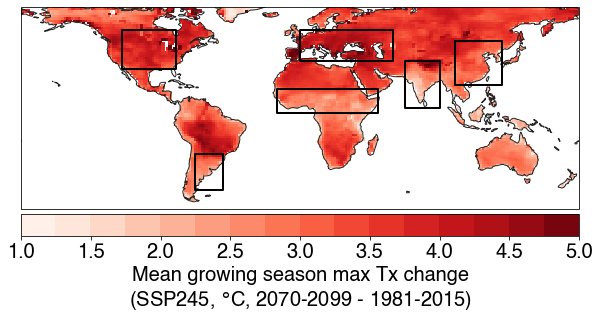

In [26]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())


ax.set_extent([-180, -180, 70, -60])
v1 = 1
v2 = 5.01
vstep = .25
vlabelstep = .5

midnorm = MidpointNormalize(vmin=v1, vcenter=(v1+v2)/2, vmax=v2)
cmap = plt.cm.get_cmap('Reds')

c = plt.pcolormesh(regridMesh['lon'], regridMesh['lat'], \
                 np.nanmean(tasmax_grow_max_chg_ssp245, axis=0), \
                 cmap=cmap, norm=midnorm)

if region == 'global':
    ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')
else:
    ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')

    
plot_polygon(ax, region_us)
plot_polygon(ax, region_europe)
plot_polygon(ax, region_india)
plot_polygon(ax, region_china)
plot_polygon(ax, region_sahel)
plot_polygon(ax, region_sa)
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Mean growing season max Tx change\n(SSP245, $\degree$C, 2070-2099 - 1981-2015)', fontsize=20)

plt.savefig('tx-fut-chg-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)


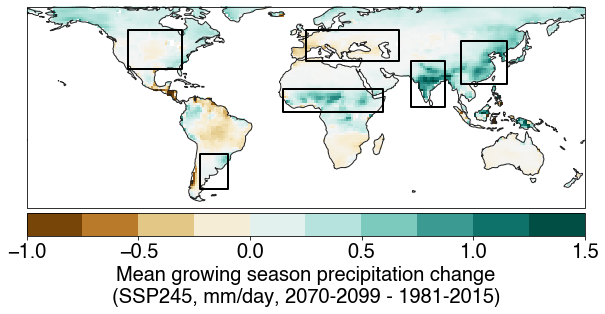

In [25]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())


ax.set_extent([-180, -180, 70, -60])
v1 = -1
v2 = 1.51
vstep = .25
vlabelstep = .5

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('BrBG')

c = plt.pcolormesh(regridMesh['lon'], regridMesh['lat'], \
                 np.nanmean(pr_grow_chg_ssp245, axis=0), \
                 cmap=cmap, norm=midnorm)

if region == 'global':
    ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')
else:
    ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')

plot_polygon(ax, region_us)
plot_polygon(ax, region_europe)
plot_polygon(ax, region_india)
plot_polygon(ax, region_china)
plot_polygon(ax, region_sahel)
plot_polygon(ax, region_sa)
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Mean growing season precipitation change\n(SSP245, mm/day, 2070-2099 - 1981-2015)', fontsize=20)

plt.savefig('pr-fut-chg-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)


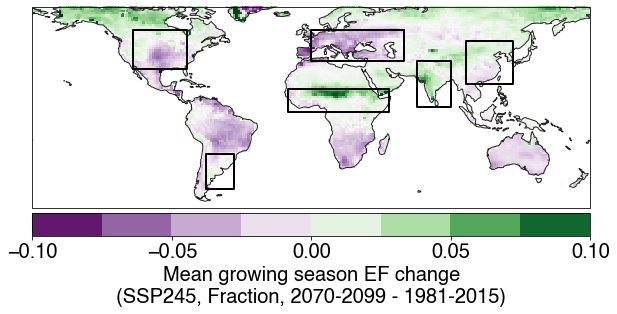

In [34]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())


ax.set_extent([-180, -180, 70, -60])
v1 = -.1
v2 = .101
vstep = .025
vlabelstep = .05

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('PRGn')

c = plt.pcolormesh(regridMesh['lon'], regridMesh['lat'], \
                 np.nanmean(ef_grow_chg_ssp245, axis=0), \
                 cmap=cmap, norm=midnorm)

if region == 'global':
    ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')
else:
    ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')

plot_polygon(ax, region_us)
plot_polygon(ax, region_europe)
plot_polygon(ax, region_india)
plot_polygon(ax, region_china)
plot_polygon(ax, region_sahel)
plot_polygon(ax, region_sa)
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Mean growing season EF change\n(SSP245, Fraction, 2070-2099 - 1981-2015)', fontsize=20)

plt.savefig('ef-fut-chg-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)


In [35]:
tasmax_grow_max_chg_ssp245_2d = tasmax_grow_max_chg_ssp245.reshape([tasmax_grow_max_chg_ssp245.shape[0], tasmax_grow_max_chg_ssp245.shape[1]*tasmax_grow_max_chg_ssp245.shape[2]])
pr_grow_chg_ssp245_2d = pr_grow_chg_ssp245.reshape([pr_grow_chg_ssp245.shape[0], pr_grow_chg_ssp245.shape[1]*pr_grow_chg_ssp245.shape[2]])
ef_grow_chg_ssp245_2d = ef_grow_chg_ssp245.reshape([ef_grow_chg_ssp245.shape[0], ef_grow_chg_ssp245.shape[1]*ef_grow_chg_ssp245.shape[2]])

In [18]:
with open('cropped_area/crop_land_regrid.dat', 'rb') as f:
    crop_all_area_regrid = pickle.load(f)
with open('cropped_area/pasture_land_regrid.dat', 'rb') as f:
    pasture_area_regrid = pickle.load(f)

In [19]:
crop_all_area_regrid_1d = np.reshape(crop_all_area_regrid, [crop_all_area_regrid.size,1])

In [20]:
%%time
if not os.path.isfile('irrigation_data_regrid_120_240.dat'):
    faoIrrigationFile = '%s/fao-irrigation/gmia_v5_aei_pct.asc'%dirAgData
    irrigationData = np.genfromtxt(faoIrrigationFile, skip_header=6)
    irrigationLat = np.linspace(90,-90,irrigationData.shape[0])
    irrigationLon = np.linspace(-180,180,irrigationData.shape[1])
    irrigationLon[irrigationLon<0] += 360

    regridder = xe.Regridder(xr.DataArray(data=irrigationData, dims=['lat', 'lon'], coords={'lat':irrigationLat, 'lon':irrigationLon}), regridMesh, 'bilinear')
    irrigation_data_regrid = regridder(irrigationData)

    with open('irrigation_data_regrid_120_240.dat', 'wb') as f:
        pickle.dump(irrigation_data_regrid, f)
else:
    with open('irrigation_data_regrid_120_240.dat', 'rb') as f:
        irrigation_data_regrid = pickle.load(f)
    irrigation_data_regrid[irrigation_data_regrid == 0] = np.nan
    irrigation_data_regrid /= 100
    irrigation_data_regrid_1d = irrigation_data_regrid.reshape([irrigation_data_regrid.shape[0]*irrigation_data_regrid.shape[1],1])

CPU times: user 1.58 ms, sys: 0 ns, total: 1.58 ms
Wall time: 45.5 ms


In [21]:
irrigation_data_regrid_1d = irrigation_data_regrid.reshape([irrigation_data_regrid.size,1])

In [36]:
bins = [0,.01,.05,.1,.2,.3, .4, .5, .6, .7, .8]
binned_tx_chg = []
binned_tx_chg_per_model = []

binned_pr_chg = []
binned_pr_chg_per_model = []

binned_ef_chg = []
binned_ef_chg_per_model = []


for b,bcur in enumerate(bins):
    if b == len(bins)-1:
        ind = np.where((crop_all_area_regrid_1d >= bcur))[0]
#         ind = np.where((crop4_area_regrid_1d >= bcur))[0]
    else:
        ind = np.where((crop_all_area_regrid_1d >= bcur) & (crop_all_area_regrid_1d < bins[b+1]))[0]
#         ind = np.where((crop4_area_regrid_1d >= bcur) & (crop4_area_regrid_1d < bins[b+1]))[0]

    binned_tx_chg.append(np.nanmean(tasmax_grow_max_chg_ssp245_2d[:,ind]))
    binned_pr_chg.append(np.nanmean(pr_grow_chg_ssp245_2d[:,ind]))
    binned_ef_chg.append(np.nanmean(ef_grow_chg_ssp245_2d[:,ind]))
    
    for m in range(tasmax_grow_max_chg_ssp245_2d.shape[0]):
        if b == 0:
            binned_tx_chg_per_model.append([])
            binned_pr_chg_per_model.append([])
            binned_ef_chg_per_model.append([])
            
        binned_tx_chg_per_model[m].append(np.nanmean(tasmax_grow_max_chg_ssp245_2d[m,ind]))
        binned_pr_chg_per_model[m].append(np.nanmean(pr_grow_chg_ssp245_2d[m,ind]))
        binned_ef_chg_per_model[m].append(np.nanmean(ef_grow_chg_ssp245_2d[m,ind]))


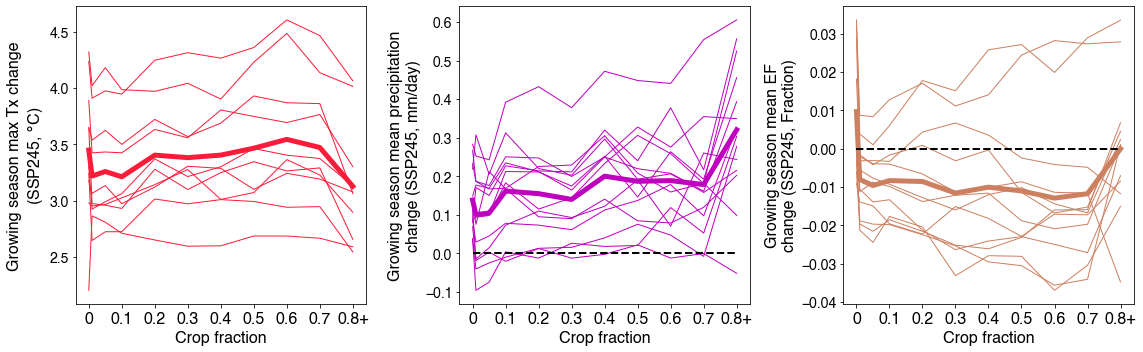

In [41]:
fig, ax = plt.subplots(1,3,figsize=(16,5))
ax[0].plot(bins,binned_tx_chg, label='Growing season max Tx', lw=5, c='#fc1c3a')
ax[0].plot(bins,np.array(binned_tx_chg_per_model).T, lw=1, c='#fc1c3a')
ax[0].set_xlabel('Crop fraction', fontsize=16)
ax[0].set_xticks(np.arange(0, .81, .1))
ax[0].set_xticklabels(['0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8+'], fontsize=16)
ax[0].set_ylabel('Growing season max Tx change\n(SSP245, $\degree$C)', fontsize=16)
# ax[0].legend(prop={'size': 14}, frameon=False)

ax[1].plot(bins, binned_pr_chg, label='Precipitation', lw=5, c='m')
ax[1].plot(bins, np.array(binned_pr_chg_per_model).T, lw=1, c='m')
ax[1].plot([0, .8], [0, 0], '--k', lw=2)
# ax[1].legend(prop={'size': 14}, frameon=False)
ax[1].set_xticks(np.arange(0, .81, .1))
ax[1].set_xticklabels(['0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8+'], fontsize=16)
# ax[1].set_yticks(fontsize=16)
ax[1].set_xlabel('Crop fraction', fontsize=16)
ax[1].set_ylabel('Growing season mean precipitation\nchange (SSP245, mm/day)', fontsize=16)

ax[2].plot(bins, binned_ef_chg, label='EF', lw=5, c='#cc8060')
ax[2].plot(bins, np.array(binned_ef_chg_per_model).T, lw=1, c='#cc8060')
ax[2].plot([0, .8], [0, 0], '--k', lw=2)
# ax[1].legend(prop={'size': 14}, frameon=False)
ax[2].set_xticks(np.arange(0, .81, .1))
ax[2].set_xticklabels(['0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8+'], fontsize=16)
# ax[1].set_yticks(fontsize=16)
ax[2].set_xlabel('Crop fraction', fontsize=16)
ax[2].set_ylabel('Growing season mean EF\nchange (SSP245, Fraction)', fontsize=16)
plt.tight_layout()

# plt.savefig('binned-changes-cmip6-future.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

(-1.0, 5.0)

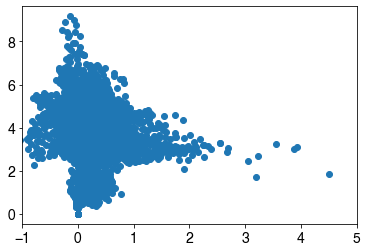

In [24]:
plt.scatter(pr_grow_chg_ssp245_2d[0,:], tasmax_grow_max_chg_ssp245_2d[0,:])
plt.xlim([-1,5])